In [39]:
import numpy as np
import matplotlib.pyplot as plt

import src.cryogenv.sim.cryosim as cryo


In [40]:
test_sim = cryo.Cryosim(record_length=2**14, sample_frequency=50e3, default=True)

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.15 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
Cryogenic simulation initialized with default components.


In [41]:
test_sim.show_modules()


{'heater': {'R_H': 0.01, 'V_H': 0.0},
 'tes': {'model': 'sigmoid', 'R_max': 0.15, 'T_mid': 0.035},
 'etm': {'n_comp': 2,
  'C_e': 2.2e-11,
  'C_a': 1.5e-10,
  'G_eb': 7.5e-09,
  'G_ea': 1.4e-10,
  'G_ab': 5e-09,
  'T_b': 0.015,
  'R_S': 0.05,
  'L': 4e-07,
  'V_B': 5e-06}}

In [42]:
test_sim.set_heater(2000e-9)         # DAC
test_sim.set_heater_tp(tp_amplitude=200e-9) # TPA

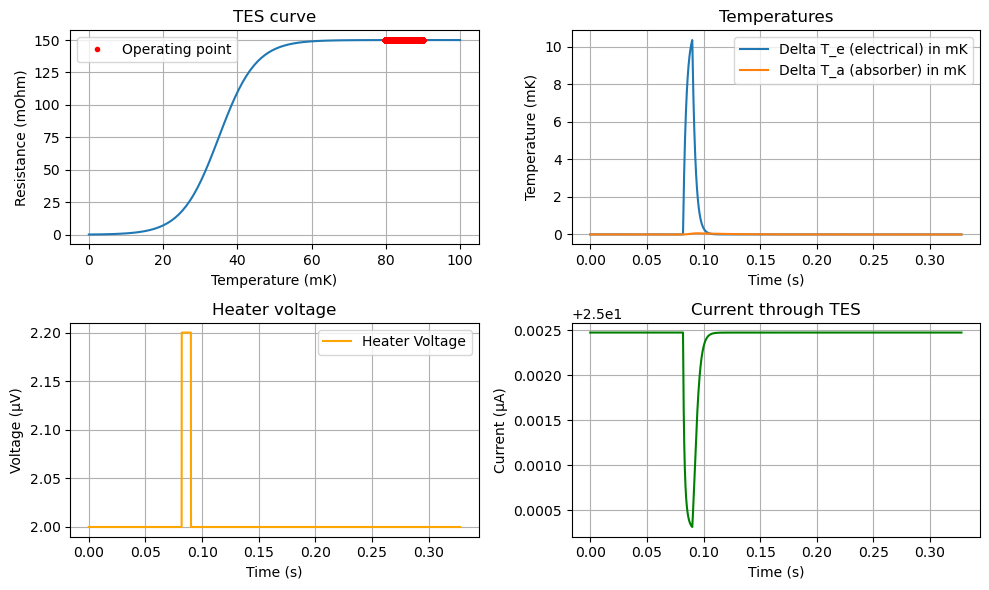

In [43]:
test_sim.render()

In [44]:
# Give out PH
print(f"Pulseheight PH is: {np.max(test_sim.I_T)-np.min(test_sim.I_T)}")

Pulseheight PH is: 2.163930801483727e-09
